In [1]:
%cd /blaze/hyeshik/p/npworks/20200222-Vero-SCV2/basemod/flg-stats

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2/basemod/flg-stats


In [2]:
annotations = pd.read_csv('../../refs/SARS-CoV-2-annotations.gff', sep='\t',
                         names=['chrom', 'type', 'name', 'start', 'end', '_x', '_y', '_z'])
annotations['start'] -= 1
cdsanno = annotations.iloc[:10]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([pd.Series(['chrSCV', 'CDS', 'ORF1ab', 265, 21555, 0.0, '.', '.'],
              index=cdsanno.columns)])
]).sort_values(by='start').reset_index(drop=True).iloc[:10, :5]

In [3]:
ORFs = cdsanno['name'].tolist()

In [4]:
mods20pct = pd.read_pickle('../../tmp/per-read-modified-bases-summary.pickle')
mods20cov = pd.read_pickle('../../tmp/per-read-modified-bases-coverage.pickle')

In [5]:
mods20cov.head()

orf,ORF1ab,S,ORF3a,E,M,ORF6,ORF7a,ORF7b,ORF8,N
pos,,,,,,,,,,
6890,416.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12787,1378.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13749,870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15947,1042.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17584,1178.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
mods20pct.head() 

orf,orf_name,ORF1ab,S,ORF3a,E,M,ORF6,ORF7a,ORF7b,ORF8,N,context,position
pos,,,,,,,,,,,,,
6890,5UTRS,0.325359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,guaaauUuugucu,6891
12787,5UTRS,0.305797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aacacaAcaaagg,12788
13749,5UTRS,0.347477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,uuuaagUuuagaa,13750
15947,5UTRS,0.350575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aucaagAauccua,15948
17584,5UTRS,0.327119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,uuguugAcacugu,17585


In [7]:
cdsanno

,chrom,type,name,start,end
0,chrSCV,CDS,ORF1ab,265,21555
1,chrSCV,CDS,S,21562,25384
2,chrSCV,CDS,ORF3a,25392,26220
3,chrSCV,CDS,E,26244,26472
4,chrSCV,CDS,M,26522,27191
5,chrSCV,CDS,ORF6,27201,27387
6,chrSCV,CDS,ORF7a,27393,27759
7,chrSCV,CDS,ORF7b,27755,27887
8,chrSCV,CDS,ORF8,27893,28259
9,chrSCV,CDS,N,28273,29533


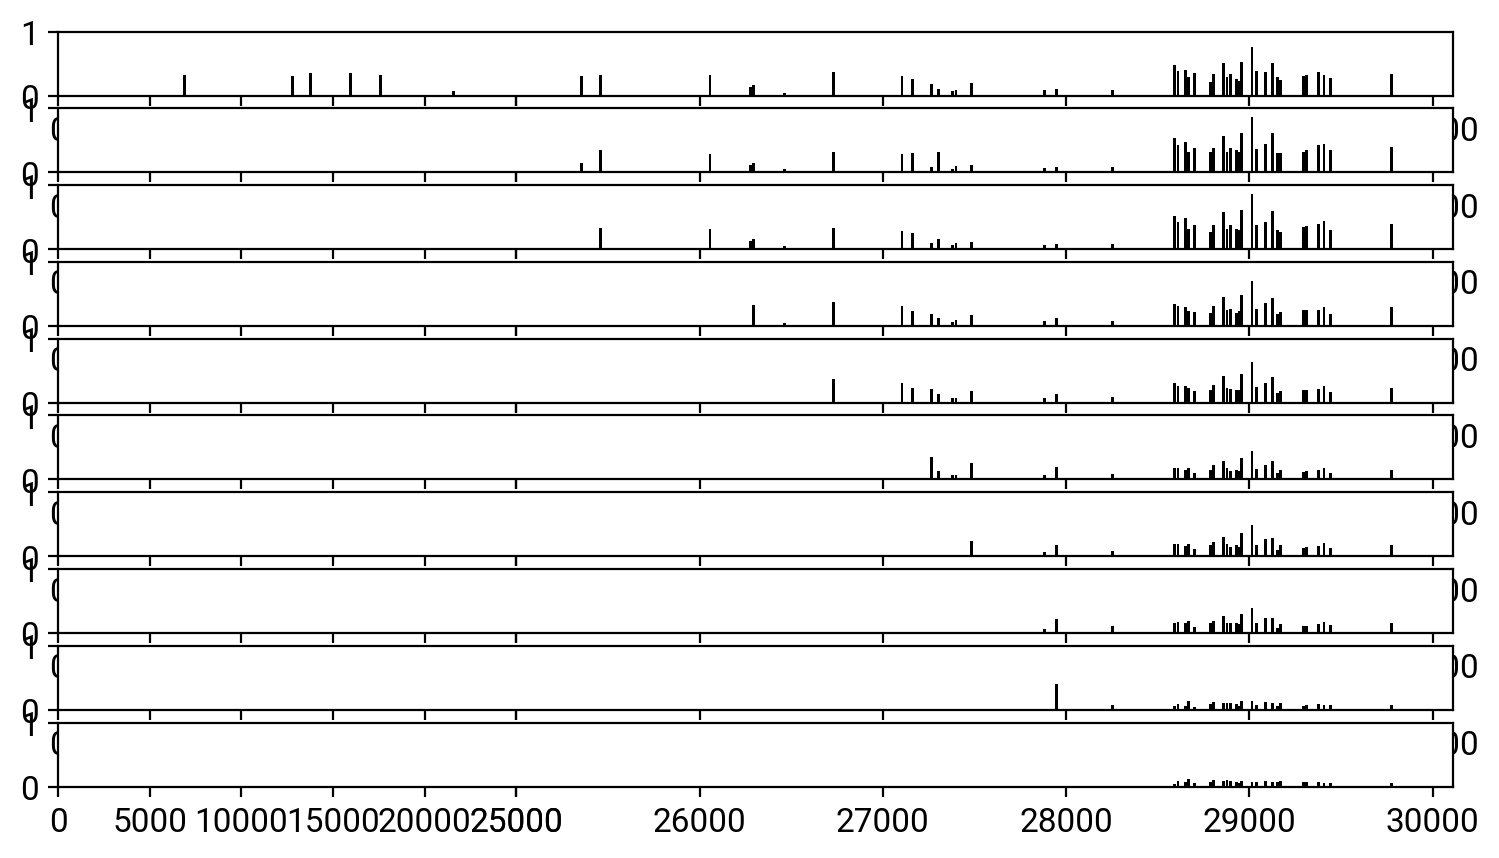

In [8]:
SHRINK_TO = 25000
SHRINK_RATIO = 1/10
def transform_to_xaxis(positions):
    ret = []
    for v in positions:
        if v >= SHRINK_TO:
            ret.append(v)
        else:
            ret.append(SHRINK_TO - (SHRINK_TO - v) * SHRINK_RATIO)
    return ret

XTICKS_MAJOR = np.hstack([np.arange(0, SHRINK_TO+1, 5000), np.arange(SHRINK_TO, 30001, 1000)])
XTICKS_TRANSFORMED = transform_to_xaxis(XTICKS_MAJOR)

MINCOVERAGE = 100
IGNORECDSENDS = 12

fig, axes = plt.subplots(10, 1, figsize=(9, 5))

for ax, orfname in zip(axes, ORFs):
    has_enough_coverage = (mods20cov[orfname] >= MINCOVERAGE)
    cdsrange = cdsanno[cdsanno['name'] == orfname].iloc[0]
    
    in_range = (
        mods20pct.index.to_series() >= (cdsrange['start'] + IGNORECDSENDS))

    ax.bar(transform_to_xaxis(mods20pct[orfname].index),
           mods20pct[orfname] * has_enough_coverage * in_range, width=15, fc='black')
    ax.set_ylim(0, 1)
    ax.set_xticks(XTICKS_TRANSFORMED)
    ax.set_xticklabels(XTICKS_MAJOR)


In [9]:
from matplotlib import cm, colors
from copy import deepcopy

In [10]:
def transform_to_xaxis(positions):
    ret = []
    for v in positions:
        if v >= REGIONS_BOUNDARY:
            ret.append((v - REGIONS_BOUNDARY) * REGION2_RATIO + REGIONS_BOUNDARY * REGION1_RATIO)
        else:
            ret.append(v * REGION1_RATIO)
    return ret

MINCOVERAGE = 100
IGNORECDSENDS = 12

BARLENGTH = 7500 # 0-25000 -> 2500, 25000->30000 -> 5000 = 7500
REGIONS_BOUNDARY = 25000
REGION1_RATIO = 1/10
REGION2_RATIO = 1
BAR_WIDTH = 24 # px

XTICKS_MAJOR = np.hstack([np.arange(0, SHRINK_TO+1, 5000), np.arange(SHRINK_TO, 30001, 1000)])
XTICKS_TRANSFORMED = transform_to_xaxis(XTICKS_MAJOR)
COLORMAP_GAMMA = 0.75

def build_heat_bar(scores, posleftlim):
    dpoints = np.zeros(BARLENGTH, np.float64)
    for pos, score in scores.sort_values().iteritems():
        if pos >= REGIONS_BOUNDARY:
            vpos = (pos - REGIONS_BOUNDARY) * REGION2_RATIO + REGIONS_BOUNDARY * REGION1_RATIO
        else:
            vpos = pos * REGION1_RATIO
        
        draw_range = np.arange((vpos - BAR_WIDTH//2), (vpos + BAR_WIDTH//2)).astype(int)
        dpoints[draw_range] = score

    vleftlim = int(transform_to_xaxis([posleftlim])[0])
    if vleftlim > 0:
        dpoints[:vleftlim] = np.nan

    return dpoints

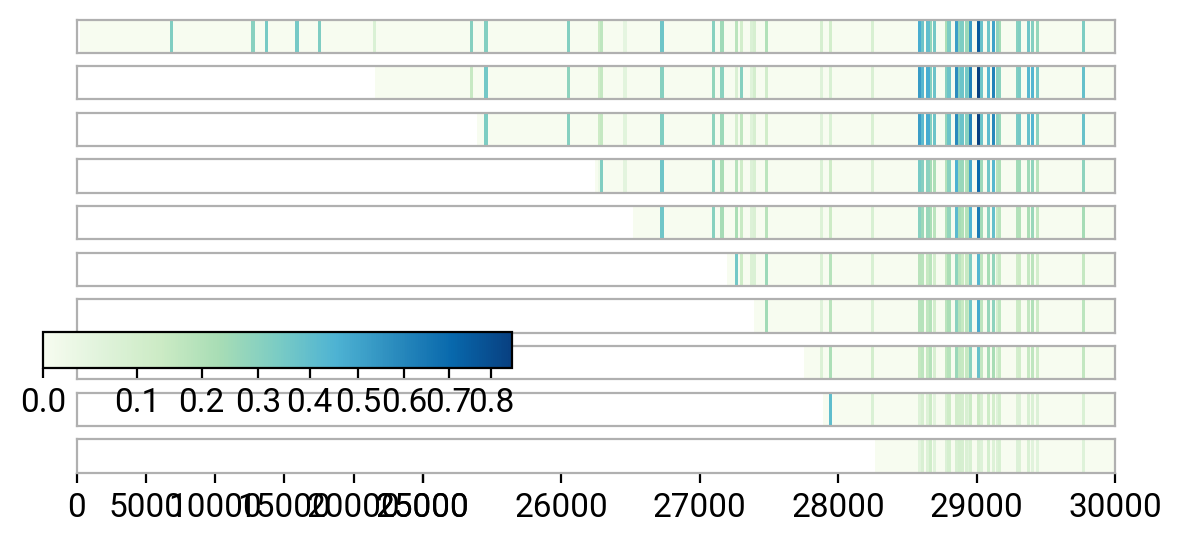

In [11]:
fig, axes = plt.subplots(10, 1, figsize=(6.7, 3))

for ax, orfname in zip(axes, ORFs):
    has_enough_coverage = (mods20cov[orfname] >= MINCOVERAGE)
    cdsrange = cdsanno[cdsanno['name'] == orfname].iloc[0]

    in_range = (
        mods20pct.index.to_series() >= (cdsrange['start'] + IGNORECDSENDS))

    filtered_score = mods20pct[orfname] * has_enough_coverage * in_range

    heatscores = build_heat_bar(filtered_score, cdsrange['start'])

    cmb = ax.pcolor([heatscores], vmin=0, vmax=0.85, cmap='GnBu', norm=colors.PowerNorm(COLORMAP_GAMMA))
    ax.set_ylim(0, 1)
    ax.set_xticks(XTICKS_TRANSFORMED)
    ax.set_xticklabels(XTICKS_MAJOR)

    for direction in 'top bottom left right'.split():
        plt.setp(ax.spines[direction], edgecolor='#b0b0b0')
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_yticklines(), visible=False)
    if orfname != 'N':
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_xticklines(), visible=False)

cbar_ax = fig.add_axes([0.1, 0.3, 0.35, 0.06])
fig.colorbar(cmb, cax=cbar_ax, orientation='horizontal')
plt.subplots_adjust(hspace=.4)

plt.savefig('../../figure-outputs/cand-modification-positions.pdf')